In [54]:
import codecs
from os import path
import pandas as pd
import pdb
import logging
import re
from gensim import parsing
import gensim
from gensim.parsing.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [56]:
training_file = path.join('semeval2016-task6-trainingdata.txt')
training_data = pd.read_csv(training_file, header=0, delimiter='\t')

In [57]:
testing_file = path.join('SemEval2016-Task6-subtaskA-testdata-gold.txt')
testing_data = pd.read_csv(testing_file,header=0, delimiter='\t')

In [58]:
def preprocess(text):
    #convert text to lower case
    text = text.lower()
   
    #removing whitespace
    text.strip()

    #removing digits
    text = gensim.parsing.preprocessing.strip_numeric(text)
    #text = ' '.join(s for s in text.split() if not any(c.isdigit() for c in s))
    
    #remove stopwords
    text = gensim.parsing.preprocessing.remove_stopwords(text)
    
    #strip punctutation
    text = gensim.parsing.preprocessing.strip_punctuation(text)
    
    #strip multiple whitepsace that might occur after we remove stopwords
    text = gensim.parsing.preprocessing.strip_multiple_whitespaces(text)

    p = PorterStemmer()
    
    text = ' '.join(p.stem(word) for word in text.split())    

    #print(text)
    
    return text

In [59]:
training_data['Tweet'] = training_data['Tweet'].map(preprocess)

In [60]:
testing_data['Tweet'] = testing_data['Tweet'].map(preprocess)

In [61]:
training_data = training_data[training_data.Target == "Legalization of Abortion"]

In [62]:
testing_data = testing_data[testing_data.Target== "Legalization of Abortion"]

In [63]:
X_train = training_data["Tweet"]

In [64]:
X_train = np.asarray([stance for stance in training_data["Tweet"]])

In [65]:
Y_train = np.asarray([stance for stance in training_data["Stance"]])

In [66]:
X_test = np.asarray([stance for stance in testing_data["Tweet"]])

In [67]:
Y_test = np.asarray([stance for stance in testing_data["Stance"]])

In [68]:
type(Y_train)

numpy.ndarray

In [69]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [70]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_train.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_training = X_train[training_indices]
y_training = Y_train[training_indices]



In [71]:
training_indices

array([510, 365, 382])

In [72]:
# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_train,training_indices,axis=0)
y_pool = np.delete(Y_train,training_indices,axis=0)

In [73]:
len(y_pool)

600

In [74]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=1, 
                              binary=True, norm='l2', use_idf=True, 
                              smooth_idf=False, sublinear_tf=True, encoding='latin1')

In [75]:
X_training = vectorizer.fit_transform(X_training)
X_testing = vectorizer.transform(X_test)
X_pool_tifd = vectorizer.transform(X_pool)

In [76]:
X_testing.shape

(280, 42)

In [77]:
Y_test.shape

(280,)

In [78]:
type(X_pool_tifd)

scipy.sparse._csr.csr_matrix

In [79]:
X_pool_tifd=X_pool_tifd.todense()
X_pool_tifd = np.asarray(X_pool_tifd)

In [80]:
type(y_pool)

numpy.ndarray

In [81]:
y_pool = np.asarray([stance for stance in y_pool])

In [82]:
type(y_training)

numpy.ndarray

In [83]:
X_training.shape

(3, 42)

In [84]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
# initializing the learner
learner = ActiveLearner(
    estimator=SVC(kernel="rbf",probability=True),
    X_training=X_training, y_training=y_training,
    query_strategy=uncertainty_sampling
)


In [85]:
unqueried_score = learner.score(X_testing, Y_test)

In [86]:
unqueried_score

0.31785714285714284

In [87]:
type(y_pool[100].reshape(1, ))

numpy.ndarray

In [88]:
# query_index, query_instance = learner.query(X_pool_tifd)

In [89]:
# X = X_pool_tifd[query_index].reshape(1, -1)

In [90]:
# X.shape

In [91]:
# y = y_pool[query_index].reshape(1, )

In [92]:
# y.shape

In [93]:
# type(y)

In [94]:
# learner.teach(X=X,y=y)

In [96]:
N_QUERIES = 30
performance_history = [unqueried_score]

for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool_tifd,n_instances = 20)
    X = X_pool[query_index]
    X = vectorizer.transform(X)
    y = y_pool[query_index]
    learner.teach(X=X,y=y)
    X_pool_tifd = np.delete(X_pool_tifd,query_index,axis=0)
    y_pool = np.delete(y_pool,query_index,axis=0)
    model_accuracy = learner.score(X_testing, Y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    performance_history.append(model_accuracy)

Accuracy after query 1: 0.6750
Accuracy after query 2: 0.5143
Accuracy after query 3: 0.4893
Accuracy after query 4: 0.6750
Accuracy after query 5: 0.6893
Accuracy after query 6: 0.6750
Accuracy after query 7: 0.6679
Accuracy after query 8: 0.6714
Accuracy after query 9: 0.6714
Accuracy after query 10: 0.6750
Accuracy after query 11: 0.6750
Accuracy after query 12: 0.6643
Accuracy after query 13: 0.6714
Accuracy after query 14: 0.6714
Accuracy after query 15: 0.6714
Accuracy after query 16: 0.6714
Accuracy after query 17: 0.6714
Accuracy after query 18: 0.6714
Accuracy after query 19: 0.6714
Accuracy after query 20: 0.6714
Accuracy after query 21: 0.6714
Accuracy after query 22: 0.6714
Accuracy after query 23: 0.6679
Accuracy after query 24: 0.6679
Accuracy after query 25: 0.6679
Accuracy after query 26: 0.6679
Accuracy after query 27: 0.6679
Accuracy after query 28: 0.6679
Accuracy after query 29: 0.6679
Accuracy after query 30: 0.6679


In [97]:
active_mc = []
mcrun = 0

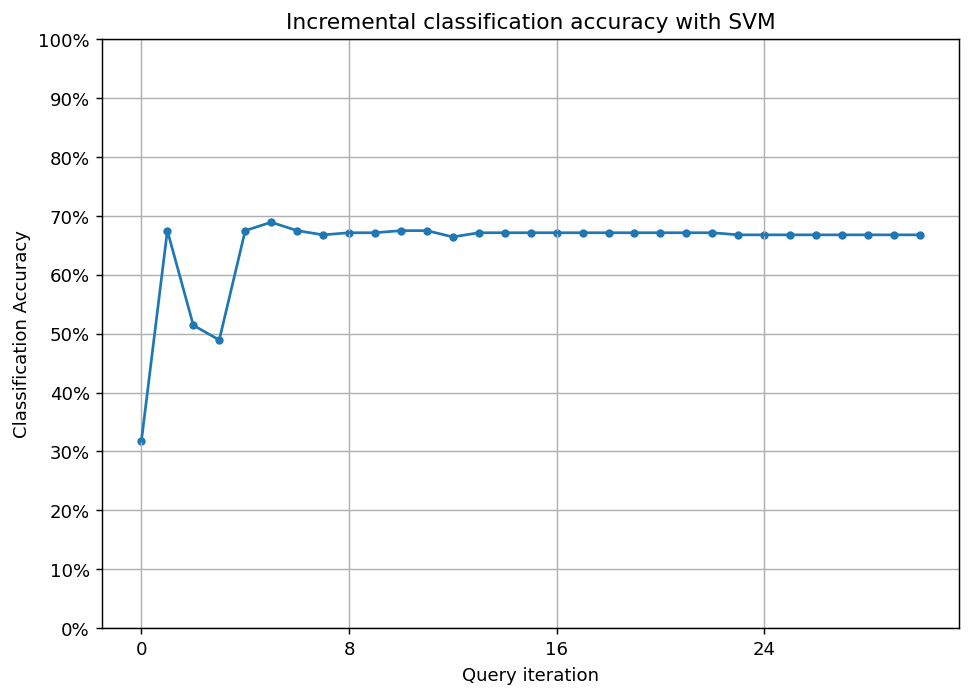

In [100]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy with SVM')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [101]:
fig.savefig('SVM_fig.jpg')

# BERT

In [ ]:
from transformers import AutoModel # For BERTs

model = AutoModel.from_pretrained("prajjwal1/bert-tiny") 

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny") 

In [ ]:
def tokenize_function(dataset):
    model_inputs = tokenizer(dataset['text'], padding="max_length", max_length=100, truncation=True)
    return model_inputs